In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arrow
import re
import warnings

warnings.filterwarnings('ignore')

In [2]:
events_calendar = pd.read_csv('./data/events_calendar.csv')
product_data = pd.read_csv('./data/product_data.csv')
product_history = pd.read_csv('./data/product_history.csv')

The below product_data table has been modified to extract useable features:
* when_added_ts --> date_added
* name --> memory, storage, colors

See next 7 segments of code

In [3]:
product_data

,fsn,when_added_ts,name,brand
0,7PV3UBG,1552895809,HTC Desire 826 White Birch 16 GB 2 GB RAM,HTC
1,PV6ANW5,1552895849,HTC Desire 826 Blue Lagoon 16 GB 2 GB RAM,HTC
2,KG8YUGQ,1552895851,HTC Desire 620G Dual Sim Santorini White 8 GB ...,HTC
3,SSPZWYU,1552895892,HTC Desire 820S Milkyway Grey 16 GB 2 GB RAM,HTC
4,XA5SMHW,1552895940,HTC U11 Solar Red 128 GB 6 GB RAM,HTC
...,...,...,...,...
3685,EXZ33N7,1625594940,DIZO Star 300 Blue,DIZO
3686,RJHQYCS,1625594940,DIZO Star 500 Black,DIZO
3687,ZREM5XC,1625594942,DIZO Star 500 Green,DIZO
3688,RZACVFY,1625594942,DIZO Star 500 Silver,DIZO


In [4]:
product_data['date_added'] = pd.to_datetime(product_data.when_added_ts.apply(lambda x: arrow.get(x).date()))

We see that the pattern for memory is 'X gb/tb ram', so we search for it and use it, otherwise we put NaN.

Similarly, the pattern for storage is 'X gb ram'.

In [5]:
def extract_memory(sentence):
    words = re.findall(r'\b\w+\b', sentence.lower())
    sLen = len(words)
    for i in range(sLen-1):
        if words[i] == 'gb' and words[i+1] == 'ram':
            return int(words[i-1])
    
    return np.NaN

In [6]:
def extract_storage(sentence):
    words = re.findall(r'\b\w+\b', sentence.lower())
    sLen = len(words)
    for i in range(sLen):
        if words[i] in {'gb', 'tb'} and (i+1 == sLen or words[i+1] != 'ram'):
            return int(words[i-1]) * (1024 if words[i] == 'tb' else 1)
    
    return np.NaN

In [7]:
product_data['memory'] = product_data.name.str.lower().apply(extract_memory)
product_data['storage'] = product_data.name.str.lower().apply(extract_storage)

Color is a bit more problematic.

Some phones have multiple colors, others use pseudo-colors like 'Fancy Sunset' and such.

I try to map most major color variants to the base colors and represent colors as a list.

I settle on a total of 15 base colors that can be turned later to multiple one-hot features, or some other embedding.

In [8]:
import re

def extract_color_phrases(sentence):
    # Define a list of common color names
    colors = [
        'red', 'coral', 'peach', 'saffron',
        'blue', 'ocean',
        'green', 'jade',
        'neon',
        'yellow',
        'orange', 'sun',
        'purple', 'diamond', 'prism', 'fantastic', 'glowing', 'dancing', 'mauve', 'violet',
        'black', 'graphite', 'dark', 'midnight', 'shadow', 'velocity', 'moonlight', 'noir',
        'white', 'pearl', 'midday', 'day', 'snowfall',
        'silver', 'crystal', 'ice', 'platinum', 'nordic', 'snow',
        'brown', 'nebula',
        'pink', 'sunset',
        'cyan', 'melody', 'sea', 'bay', 'aurora', 'fantasy', 'sky', 'waves', 'nitro', 'aqua', 'wave',
        'gray', 'grey', 'titanium',
        'gold', 'starlight', 'champagne', 'marigold', 'golden'
    ]

    # Tokenize the sentence into words
    words = re.findall(r'\b\w+\b', sentence.lower())

    color_phrases = []

    # Iterate through the words and check for color names
    for word in words:
        if word in colors:
            if word in {'grey', 'gray', 'titanium'}:
                color_phrases.append('gray')
            elif word in {'purple', 'diamond', 'prism', 'fantastic', 'glowing', 'dancing', 'mauve', 'violet'}:
                color_phrases.append('purple')
            elif word in {'silver', 'crystal', 'ice', 'platinum', 'nordic', 'snow'}:
                color_phrases.append('silver')
            elif word in {'orange', 'sun'}:
                color_phrases.append('orange')
            elif word in {'blue', 'ocean'}:
                color_phrases.append('blue')
            elif word in {'brown', 'nebula'}:
                color_phrases.append('brown')
            elif word in {'green', 'jade'}:
                color_phrases.append('green')
            elif word in {'pink', 'sunset'}:
                color_phrases.append('pink')
            elif word in {'white', 'pearl', 'midday', 'day', 'snowfall'}:
                color_phrases.append('white')
            elif word in {'cyan', 'melody', 'sea', 'bay', 'aurora', 'fantasy', 'sky', 'waves', 'nitro', 'aqua', 'wave'}:
                color_phrases.append('cyan')
            elif word in {'black', 'graphite', 'dark', 'midnight', 'shadow', 'velocity', 'moonlight', 'noir'}:
                color_phrases.append('black')
            elif word in {'red', 'coral', 'peach', 'saffron'}:
                color_phrases.append('red')
            elif word in {'gold', 'starlight', 'champagne', 'marigold', 'golden'}:
                color_phrases.append('gold')
            else:
                color_phrases.append(word)

    return np.unique(color_phrases).tolist()

In [9]:
product_data['colors'] = product_data.name.str.lower().apply(extract_color_phrases)

A final word on these features.

Generally, I would expect that such features are already available if coming directly from Flipkart.

If it's a product that is only available at a competitor's website, then this data can be scraped and tabulated.

I won't do this scraping here, but note that it is possible. The best approach would be to set up a pipeline that does this automatically in conjuction with an automation and/or data engineer, but I suspect that this direction might be out-of-scope for this assignment.

Next I clean the product_history table:
* There is a segment with sales data but no conversion data, and also a segment with ads but no ppvs (0). They are very few and likely a result of no conversion information. We will fill in this data as 0.
* We also see some fsns that are all 0, a majority of which come from the NaNs, so we exclude those.
* Finally, I note that there might be some gap dates. I won't take care of this now during the cleaning process, but in later steps when doing timeseries analysis.

In [10]:
sorted(product_history.data_date.unique())

['2022-01-01',
 '2022-01-02',
 '2022-01-03',
 '2022-01-04',
 '2022-01-05',
 '2022-01-06',
 '2022-01-07',
 '2022-01-08',
 '2022-01-09',
 '2022-01-10',
 '2022-01-11',
 '2022-01-12',
 '2022-01-13',
 '2022-01-14',
 '2022-01-15',
 '2022-01-16',
 '2022-01-17',
 '2022-01-18',
 '2022-01-19',
 '2022-01-20',
 '2022-01-21',
 '2022-01-22',
 '2022-01-23',
 '2022-01-24',
 '2022-01-25',
 '2022-01-26',
 '2022-01-27',
 '2022-01-28',
 '2022-01-29',
 '2022-01-30',
 '2022-01-31',
 '2022-02-01',
 '2022-02-02',
 '2022-02-03',
 '2022-02-04',
 '2022-02-05',
 '2022-02-06',
 '2022-02-07',
 '2022-02-08',
 '2022-02-09',
 '2022-02-10',
 '2022-02-11',
 '2022-02-12',
 '2022-02-13',
 '2022-02-14',
 '2022-02-15',
 '2022-02-16',
 '2022-02-17',
 '2022-02-18',
 '2022-02-19',
 '2022-02-20',
 '2022-02-21',
 '2022-02-22',
 '2022-02-23',
 '2022-02-24',
 '2022-02-25',
 '2022-02-26',
 '2022-02-27',
 '2022-02-28',
 '2022-03-01',
 '2022-03-02',
 '2022-03-03',
 '2022-03-04',
 '2022-03-05',
 '2022-03-06',
 '2022-03-07',
 '2022-03-

In [11]:
product_history

,fsn,alpha_gross_gmv,alpha_gross_units,alpha_impressions,alpha_primary_ppvs,data_date
0,G9GMYQM,0.0,0.0,90103.0,3571.0,2022-01-01
1,G9GMYQM,0.0,0.0,116069.0,4839.0,2022-01-02
2,G9GMYQM,0.0,0.0,94951.0,3596.0,2022-01-03
3,G9GMYQM,0.0,0.0,105292.0,4064.0,2022-01-04
4,G9GMYQM,0.0,0.0,96652.0,4057.0,2022-01-05
...,...,...,...,...,...,...
3143459,AAFCC8S,0.0,0.0,NaN,NaN,2022-07-24
3143460,AAFCC8S,0.0,0.0,NaN,NaN,2022-04-03
3143461,AAFCC8S,0.0,0.0,NaN,NaN,2022-09-01
3143462,AAFCC8S,0.0,0.0,NaN,NaN,2022-07-22


In [12]:
product_history.fillna(0, inplace=True)

In [13]:
all_fsn = product_history[(product_history.alpha_gross_gmv > 0) | (product_history.alpha_gross_units > 0) | (product_history.alpha_impressions > 0) | (product_history.alpha_primary_ppvs > 0)].fsn.unique().tolist()

In [14]:
product_history = product_history[product_history.fsn.isin(all_fsn)]

In [15]:
product_history

,fsn,alpha_gross_gmv,alpha_gross_units,alpha_impressions,alpha_primary_ppvs,data_date
0,G9GMYQM,0.0,0.0,90103.0,3571.0,2022-01-01
1,G9GMYQM,0.0,0.0,116069.0,4839.0,2022-01-02
2,G9GMYQM,0.0,0.0,94951.0,3596.0,2022-01-03
3,G9GMYQM,0.0,0.0,105292.0,4064.0,2022-01-04
4,G9GMYQM,0.0,0.0,96652.0,4057.0,2022-01-05
...,...,...,...,...,...,...
3143459,AAFCC8S,0.0,0.0,0.0,0.0,2022-07-24
3143460,AAFCC8S,0.0,0.0,0.0,0.0,2022-04-03
3143461,AAFCC8S,0.0,0.0,0.0,0.0,2022-09-01
3143462,AAFCC8S,0.0,0.0,0.0,0.0,2022-07-22


Finally, convert the date columns to a date format and begin checking date inconsistencies.

In [16]:
product_history.loc[:, 'data_date'] = pd.to_datetime(product_history.data_date)

In [17]:
events_calendar.loc[:, 'event_start_time'] = pd.to_datetime(events_calendar.event_start_time)
events_calendar.loc[:, 'event_end_time'] = pd.to_datetime(events_calendar.event_end_time)

First, let's see if we have sales prior to the date_added.
The query is more complex, so I'll use the pandasql package to help streamline the joins and filters.

In [18]:
from pandasql import sqldf

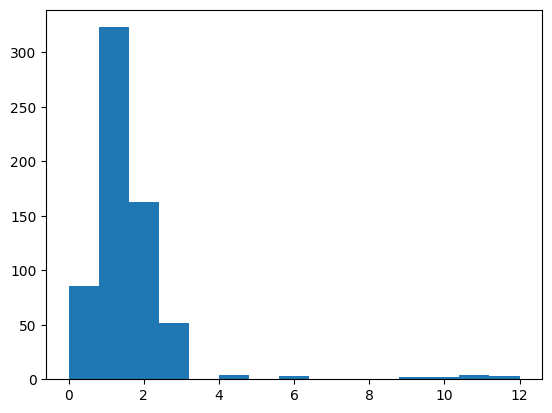

In [19]:
product_added = product_data[['fsn', 'date_added']]
lags = sqldf(
    '''
    select a.fsn,
        max(ROUND((JULIANDAY(date_added) - JULIANDAY(data_date)))) lag
    from product_added a join product_history h
        on a.fsn = h.fsn
        and a.date_added >= h.data_date
        and h.alpha_gross_units > 0
    group by a.fsn
    order by lag desc
    '''
)
_ = plt.hist(lags.lag.values, bins=15)

It seems that the largest lag from the date_add is 12 days, but most of the lags are 3 and less.
Normally, I would inquire with the data provider regarding this discrepancy.
However, we do not have this luxury here, so we can do two things:
1. Assume that date_added is with error and shift it back by the lag.
2. Assume that this implies pre-orders, and date_added is simply the date when the item officially becomes available. No modification would be made.

We also have a 3rd reason, where there is some alignment issue with the data_date column in product_history. Before arriving at a final conclusion, we can still validate this against the events_calendar data. The assumption here is that during events we should see a spike in units sold. So if there is some misalignment in data_date then we will be able to see this discrepancy there.

Let's do this analysis with a sample of 5 major products that had a lag.

In [20]:
prod_sale_bounds = product_history[(product_history.alpha_gross_units > 0) & (product_history.fsn.isin(lags.fsn.values.tolist()))].groupby(by='fsn')['data_date'].agg(['min', 'max'])
fsns = prod_sale_bounds[(prod_sale_bounds['min'] < events_calendar.event_start_time.min()) & (prod_sale_bounds['max'] > events_calendar.event_end_time.max())].index.values.tolist()
product_history[product_history.fsn.isin(fsns)].groupby(by='fsn')[['alpha_gross_units']].sum().sort_values('alpha_gross_units').tail(5)

,alpha_gross_units
fsn,
FSQYBFU,330174.0
XN6WRB3,404358.0
CFVMDCX,414570.0
BH3G73H,488836.0
V7GUFWA,602187.0


These are 5 of the largest fsns by sales with a lag that have sales data that encompass all events.

(0.0, 25000.0)

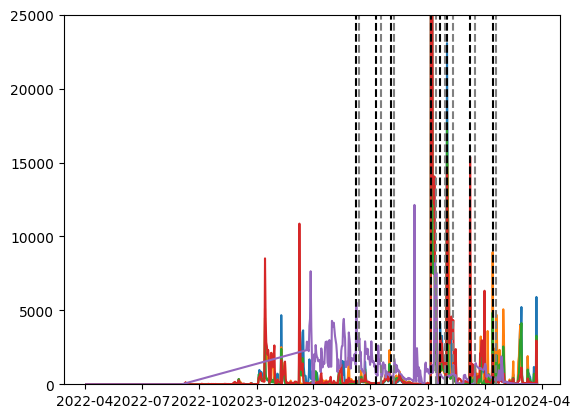

In [21]:
for fsn, fsn_data in product_history[product_history.fsn.isin(['FSQYBFU', 'XN6WRB3', 'CFVMDCX', 'BH3G73H', 'V7GUFWA'])].groupby('fsn'):
    sorted_data = fsn_data.sort_values('data_date')
    plt.plot(sorted_data.data_date, sorted_data.alpha_gross_units)
for idx, row in events_calendar.iterrows():
    plt.vlines(row.event_start_time, 0, 25000, colors='black', linestyles='dashed')
    plt.vlines(row.event_end_time, 0, 25000, colors='grey', linestyles='dashed')
plt.ylim(0, 25000)

We see that the September event (which actually happens in October) is particularly pronounced. So let's zoom in on it to get a closer look.

(19634.0, 19648.0)

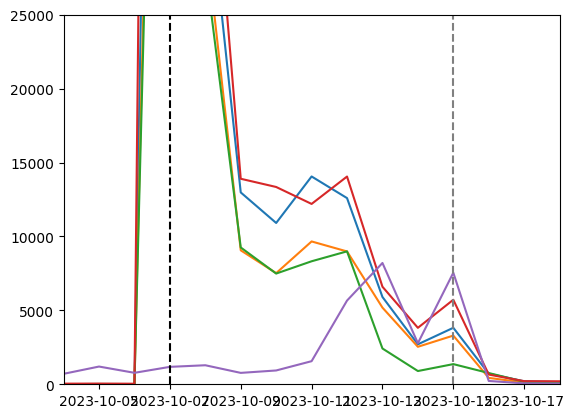

In [22]:
for fsn, fsn_data in product_history[product_history.fsn.isin(['FSQYBFU', 'XN6WRB3', 'CFVMDCX', 'BH3G73H', 'V7GUFWA'])].groupby('fsn'):
    sorted_data = fsn_data.sort_values('data_date')
    plt.plot(sorted_data.data_date, sorted_data.alpha_gross_units)
for idx, row in events_calendar.iterrows():
    plt.vlines(row.event_start_time, 0, 25000, colors='black', linestyles='dashed')
    plt.vlines(row.event_end_time, 0, 25000, colors='grey', linestyles='dashed')
plt.ylim(0, 25000)
plt.xlim(arrow.get('2023-10-04 00:00:00').datetime, arrow.get('2023-10-18 00:00:00').datetime)

It seems that the first big spikes are exactly aligned to the beginning of the event, and the last spikes are aligned to the end of the event. This is sufficient evidence to conclude that data_date is probably not missaligned. Regardless, it's possible to repeat this a few more times, either zooming in on other events or with other products. I did this by reruning the notebook cells, but I did not include it in here as they merely reaffirmed this conclusion.

So we will pick assumption #2 - preorders. Since date_added will simply help us design an 'age' feature, a potential lag of a few days is not so severe.

Now, we can use this data to try and extract some other features - like premium quality - that might be too hard to extract from the name column. We use the weighted average price of the product, where each month from release contributes half as much to the weighting, to determine classes with DBSCAN.

In [23]:
from sklearn import cluster

product_data.loc[:,'premium_cat'] = 0.

product_release_price = sqldf(
    '''
    select p.fsn,
        sum(h.alpha_gross_gmv/(ABS((JULIANDAY(h.data_date) - JULIANDAY(p.date_added))/30.5)+1))
        / sum(h.alpha_gross_units/(ABS((JULIANDAY(h.data_date) - JULIANDAY(p.date_added))/30.5)+1)) release_avg_price
    from product_added p join product_history h
        on p.fsn = h.fsn
        and ABS((JULIANDAY(h.data_date) - JULIANDAY(p.date_added))/30.5) < 30
    group by p.fsn
    '''
)

product_data = product_data.merge(product_release_price)

In [24]:
mask = (product_data.brand == 'Apple') & \
    (product_data.memory.isna()) & \
    (product_data.storage == 256) & \
    (product_data.date_added <= pd.Timestamp('2022-03-18')) & \
    (product_data.date_added >= pd.Timestamp('2022-03-05')) & \
    (~product_data.release_avg_price.isna())

prods = product_data[mask]

gridSize = (np.log(prods.release_avg_price.max()/prods.release_avg_price.min()))/len(prods)

res = cluster.DBSCAN(eps=gridSize, min_samples=1).fit(np.log(prods.release_avg_price.values).reshape(-1, 1)).labels_
mapping = dict()
min_val = np.inf
for i in np.unique(res):
    mapping[i] = prods.release_avg_price.values[res == i].mean()
    if mapping[i] < min_val:
        min_val = mapping[i]
for i in np.unique(res):
    mapping[i] /= min_val
product_data.loc[mask,'premium_cat'] = np.array(list(map(mapping.get, res)))

In [25]:
product_data[mask]

,fsn,when_added_ts,name,brand,date_added,memory,storage,colors,premium_cat,release_avg_price
176,MZYFNDT,1647066790,Apple iPhone SE 3rd Gen Midnight 256 GB,Apple,2022-03-12,NaN,256.0,[black],1.000000,48842.199303
182,QHH6VX9,1647066840,"Apple iPhone SE 3rd Gen Product Red 256 GB, Pr...",Apple,2022-03-12,NaN,256.0,[red],1.000000,46928.083087
183,3UYTKYB,1647066848,Apple iPhone 13 mini Green 256 GB,Apple,2022-03-12,NaN,256.0,[green],1.454127,72255.150016
186,HG86FDG,1647066872,Apple iPhone SE 3rd Gen Starlight 256 GB,Apple,2022-03-12,NaN,256.0,[gold],1.000000,47763.279540
190,XEZZJ2G,1647066896,Apple iPhone 13 Pro Alpine Green 256 GB,Apple,2022-03-12,NaN,256.0,[green],2.437541,110376.121520
192,3SQEVZE,1647066904,Apple iPhone 13 Pro Max Alpine Green 256 GB,Apple,2022-03-12,NaN,256.0,[green],2.437541,122869.850459
193,XQNTXDW,1647066914,Apple iPhone 13 Green 256 GB,Apple,2022-03-12,NaN,256.0,[green],1.454127,66888.878569


We see that this method is pretty good at categorizing some kind of 'premium' measure.

In [26]:
for i, (gb, df) in enumerate(product_data.groupby(['brand', 'memory', 'storage', 'date_added'], dropna=False)):
    mask = (product_data.brand == gb[0]) & \
        ((product_data.memory == gb[1]) | (product_data.memory.isna() & np.isnan(gb[1]))) & \
        ((product_data.storage == gb[2]) | (product_data.storage.isna() & np.isnan(gb[2]))) & \
        (product_data.date_added <= gb[3] + pd.Timedelta(7, 'D')) & \
        (product_data.date_added >= gb[3] - pd.Timedelta(7, 'D')) & \
        (~product_data.release_avg_price.isna()) & \
        (product_data.premium_cat == 0)
    
    if mask.sum() == 0:
        product_data.loc[mask,'premium_cat'] = 1
        continue

    prods = product_data[mask]

    gridSize = (np.log(prods.release_avg_price.max()/prods.release_avg_price.min()))/len(prods)

    if gridSize == 0:
        product_data.loc[mask,'premium_cat'] = 1
        continue
    
    res = cluster.DBSCAN(eps=gridSize, min_samples=1).fit(np.log(prods.release_avg_price.values).reshape(-1, 1)).labels_
    mapping = dict()
    min_val = np.inf
    for j in np.unique(res):
        mapping[j] = prods.release_avg_price.values[res == j].mean()
        if mapping[j] < min_val:
            min_val = mapping[j]
    for j in np.unique(res):
        mapping[j] /= min_val
    product_data.loc[mask,'premium_cat'] = np.array(list(map(mapping.get, res)))


In [27]:
product_data

,fsn,when_added_ts,name,brand,date_added,memory,storage,colors,premium_cat,release_avg_price
0,DMKCGQS,1569165217,Apple iPhone 11 Pro Max Space Grey 64 GB,Apple,2019-09-22,NaN,64.0,[gray],1.463006,116943.116593
1,GYSAS9X,1569165222,Apple iPhone 11 Pro Space Grey 256 GB,Apple,2019-09-22,NaN,256.0,[gray],1.000000,121300.000000
2,PAYNSGG,1569165225,Apple iPhone 11 Pro Max Gold 64 GB,Apple,2019-09-22,NaN,64.0,[gold],0.000000,NaN
3,JCWYGCC,1569165231,Apple iPhone 11 Pro Midnight Green 512 GB,Apple,2019-09-22,NaN,512.0,"[black, green]",1.000000,140400.000000
4,YWUW8HP,1569165235,Apple iPhone 11 Pro Space Grey 64 GB,Apple,2019-09-22,NaN,64.0,[gray],0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
2918,EXZ33N7,1625594940,DIZO Star 300 Blue,DIZO,2021-07-06,NaN,NaN,[blue],1.000000,1268.964816
2919,RJHQYCS,1625594940,DIZO Star 500 Black,DIZO,2021-07-06,NaN,NaN,[black],1.487534,1819.623522
2920,ZREM5XC,1625594942,DIZO Star 500 Green,DIZO,2021-07-06,NaN,NaN,[green],1.487534,1999.000000
2921,RZACVFY,1625594942,DIZO Star 500 Silver,DIZO,2021-07-06,NaN,NaN,[silver],1.487534,1869.952740


With this, we finish all data preprocessing/cleaning and pickle our tables

In [28]:
product_data.to_pickle('./data/product_data.pickle')
product_history.to_pickle('./data/product_history.pickle')
events_calendar.to_pickle('./data/events_calendar.pickle')